In [2]:
!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376416 sha256=d8c42d6503ba1573c2d607cca4881537b29720366ded9e9bda72cd1696afed24
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set up Colab

In [17]:
continuous = False
gravity = -10
enable_wind = False
wind_power = 15
turbulence_power = 1.5
render = True

env = gym.make('LunarLander-v3', continuous=continuous, gravity=gravity,
               enable_wind=enable_wind, wind_power=wind_power,
               turbulence_power=turbulence_power,
               render_mode='rgb_array' if render else None)

if 'inline' in matplotlib.get_backend():
  from IPython import display
plt.ion()

device = torch.device('cuda' if torch.cuda.is_available() else
                      'mps' if torch.backends.mps.is_available() else 'cpu')

# Replay Memory

In [8]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

  def __init__(self, capacity):
    self.memory = deque([], maxlen=capacity)

  def push(self, *args):
    self.memory.append(Transition(*args))

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

# Q Network

In [5]:
class DQN(nn.Module):

  def __init__(self, n_observations, n_actions):
    super(DQN, self).__init__()
    self.layer1 = nn.Linear(n_observations, 128)
    self.layer2 = nn.Linear(128, 128)
    self.layer3 = nn.Linear(128, n_actions)

  def forward(self, x):
    return self.layer3(F.relu(self.layer2(F.relu(self.layer1(x)))))

# Setting up Training

In [9]:
batch_size = 128
gamma = 0.99
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000
tau = 0.005
lr = 0.0001

n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
  global steps_done
  sample = random.random()
  eps_threshold = eps_end+(eps_start-eps_end)*math.exp(-steps_done/eps_decay)
  steps_done+=1
  if sample>eps_threshold:
    with torch.no_grad():
      return policy_net(state).max(1).indices.view(1, 1)
  else:
    return torch.tensor([[env.action_space.sample()]], device=device,
                        dtype=torch.long)


episode_durations = []

def plot_durations(show_result=False):
  plt.figure(1)
  durations_t = torch.tensor(episode_durations, dtype=torch.float)
  if show_result:
    plt.title('Result')
  else:
    plt.clf()
    plt.title('Training...')
  plt.xlabel('Episode')
  plt.ylabel('Duration')
  plt.plot(durations_t.numpy())

  if len(durations_t) >= 100:
    means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(99), means))
    plt.plot(means.numpy())

  plt.pause(0.001)
  if 'inline' in matplotlib.get_backend():
    if not show_result:
      display.display(plt.gcf())
      display.clear_output(wait=True)
    else:
      display.display(plt.gcf())

# Optimizing

In [ ]:
def optimize_model():
  if len(memory)<batch_size:
    return
  transitions = memory.sample(batch_size)
  batch = Transition(*zip(*transitions))

  non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device,
                                dtype=torch.bool)
  non_final_next_states = torch.cat([s for s in batch.next_state
                                     if s is not None])

  state_batch = torch.cat(batch.state)
  action_batch = torch.cat(batch.action)
  reward_batch = torch.cat(batch.reward)

  state_action_values = policy_net(state_batch).gather(1, action_batch)

  next_state_values = torch.zeros(batch_size, device=device)
  with torch.no_grad():
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
  expected_state_action_values = (next_state_values*gamma)+reward_batch

  criterion = nn.SmoothL1Loss()
  loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

  optimizer.zero_grad()
  loss.backward()

  torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
  optimizer.step()

# Training

Complete


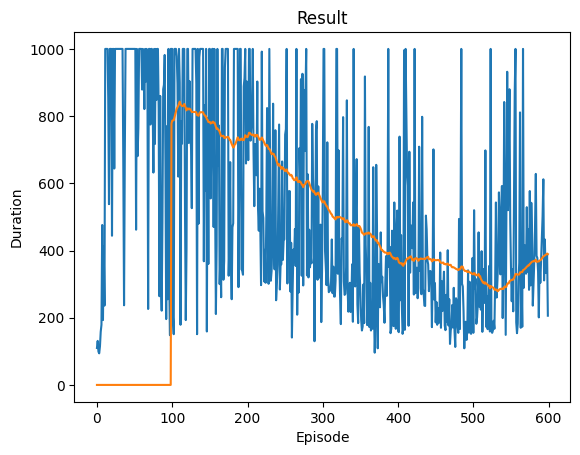

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
num_episodes = 600

for i_episode in range(num_episodes):
  state, info = env.reset()
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
  for t in count():
    action = select_action(state)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated

    if terminated:
      next_state = None
    else:
      next_state = torch.tensor(observation, dtype=torch.float32,
                                device=device).unsqueeze(0)

    memory.push(state, action, next_state, reward)

    state = next_state
    optimize_model()

    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
      target_net_state_dict[key] = policy_net_state_dict[key]*tau+target_net_state_dict[key]*(1-tau)
    target_net.load_state_dict(target_net_state_dict)

    if done:
      episode_durations.append(t+1)
      plot_durations()
      break

  if i_episode % 10 == 0:
    torch.save(policy_net.state_dict(), 'policy_net.pth')
    torch.save(target_net.state_dict(), 'target_net.pth')

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

# Testing

In [18]:
from pathlib import Path
import numpy as np

policy_net = DQN(n_observations, n_actions).to(device)
policy_net.load_state_dict(torch.load('policy_net.pth'))

def next_action(state):
  with torch.no_grad():
    return policy_net(state).max(1).indices.view(1, 1)

state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
done = False
total_reward = 0
frames = []

while not done:
  action = next_action(state)
  state, reward, terminated, truncated, _ = env.step(action.item())
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
  frame = env.render()
  frames.append(frame)
  done = terminated or truncated
  total_reward+=reward

env.close()
print(f'Total rewards: {total_reward}')

import imageio
video_path = 'lunar_lander_test.mp4'
imageio.mimsave(video_path, frames, fps=30)

from IPython.display import HTML
from base64 import b64encode
mp4 = open(video_path,'rb').read()
video_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'<video width="640" height="480" controls><source src="{video_url}" type="video/mp4"></video>')

<ipython-input-18-56208e8fc382>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load('policy_net.pth'))


Total rewards: 260.40228335199487
